In [1]:
import os
from glob import glob
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon
from itertools import combinations

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Multiple seeds experiment

In [11]:
# Load scores from multiple runs with multiple seeds
dirpaths = glob('../experiments/data/outputs/seeds/mvn_experiment/seed_*')
scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[]}
for dirpath in dirpaths:
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['KRR-baseline'].append(foo['baseline'])
        scores['KRR-after'].append(foo['after'])
        scores['KRR-before'].append(foo['before'])

with open('../experiments/data/outputs/seeds/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    scores['RF-baseline'] = foo['baseline']
    scores['RF-after'] = foo['after']

scores_df = pd.DataFrame(scores)

In [12]:
scores_df.columns = ['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF']
scores_df.aggregate(['mean', 'median', 'std'])

,KRR,$P$-KRR,$\mathcal{H}_P$-KRR,RF,$P$-RF
mean,0.238486,0.221210,0.206073,0.276058,0.266886
median,0.233671,0.219427,0.203442,0.266962,0.260306
std,0.037743,0.025511,0.023472,0.036431,0.036740


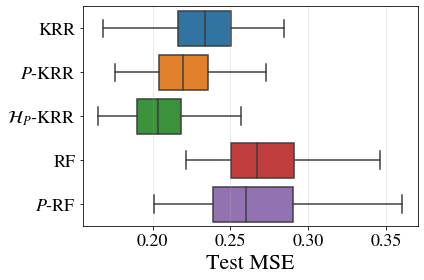

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(alpha=0.3)
sns.boxplot(data=scores_df, orient='h', showfliers=False, ax=ax)

ax.set_xlabel("Test MSE", fontsize=22)
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax.set_yticklabels(['KRR', r'$P$-KRR', r'$\mathcal{H}_P$-KRR', 'RF', r'$P$-RF'])
ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

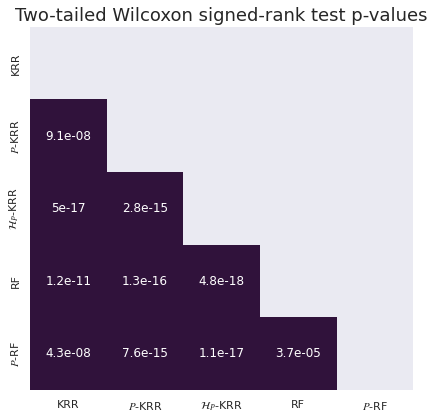

In [14]:
def paired_wilcoxon(df):
    cols = df.columns
    W_values = np.zeros((len(cols), len(cols)))
    p_values = np.zeros((len(cols), len(cols)))
    for i, j in combinations(range(len(cols)), 2):
        W, p = wilcoxon(x=df[cols[i]].values,
                        y=df[cols[j]].values)
        W_values[i, j] = W
        p_values[i, j] = p
    W_values =  W_values + W_values.T - np.eye(len(cols))
    p_values = p_values + p_values.T - np.eye(len(cols))
    W_df = pd.DataFrame(data=W_values, columns=cols, index=cols)
    p_df = pd.DataFrame(data=p_values, columns=cols, index=cols)
    return W_df, p_df

W_df, p_df_mse = paired_wilcoxon(scores_df)


sns.set(font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = np.zeros_like(p_df_mse, dtype=bool)
mask[np.triu_indices_from(mask)] = True
p_df_mse[mask] = np.nan
sns.heatmap(p_df_mse, cmap="turbo", annot=True, cbar=False, vmin=0, vmax=0.01, ax=ax) 
ax.set_title("Two-tailed Wilcoxon signed-rank test p-values", fontsize=18)
plt.tight_layout()
plt.show()

### n_train experiment

In [23]:
dirpaths = glob('../experiments/data/outputs/n_train/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'ntrain': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, ntrain = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['ntrain'].append(ntrain)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])


rf_scores = {'RF-baseline': [], 'RF-after': [], 'ntrain': [], 'seed': []}
with open('../experiments/data/outputs/n_train/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'n_train']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'ntrain']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)

In [50]:
dirpaths = glob('../experiments/data/outputs/n_train/mvn_experiment/seed_*')
scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'RF-baseline': [], 'RF-after': [],
          'ntrain': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, ntrain = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        scores['KRR-baseline'].append(foo['baseline'])
        scores['KRR-after'].append(foo['after'])
        scores['KRR-before'].append(foo['before'])
        scores['ntrain'].append(ntrain)
        scores['seed'].append(seed)
        
with open('../experiments/data/outputs/n_train/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    scores['RF-baseline'] = foo['baseline']
    scores['RF-after'] = foo['after']

scores_df = pd.DataFrame(scores)
scores_df[r'Gap $P$-RF'] = scores_df['RF-baseline'] - scores_df['RF-after']
scores_df[r'Gap $P$-KRR'] = scores_df['KRR-baseline'] - scores_df['KRR-after']
scores_df[r'Gap $\mathcal{H}_P$-KRR'] = scores_df['KRR-baseline'] - scores_df['KRR-before']
scores_df = scores_df.drop('seed', axis=1).groupby('ntrain').aggregate(['mean', 'std'])

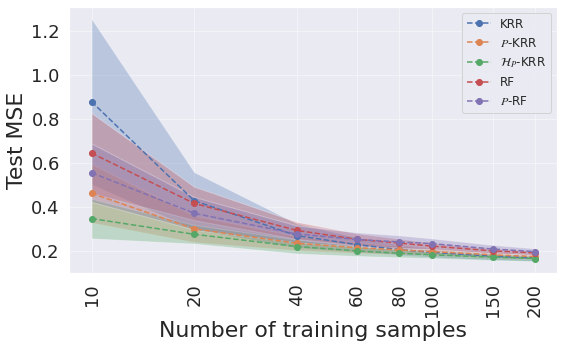

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

ntrain = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(ntrain, KRR_baseline_mean, ls='--', marker='o', label='KRR')
ax.fill_between(ntrain, KRR_baseline_lb, KRR_baseline_ub, alpha=0.3)

ax.plot(ntrain, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(ntrain, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(ntrain, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(ntrain, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(ntrain, RF_baseline_mean, ls='--', marker='o', label='RF')
ax.fill_between(ntrain, RF_baseline_lb, RF_baseline_ub, alpha=0.3)

ax.plot(ntrain, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(ntrain, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

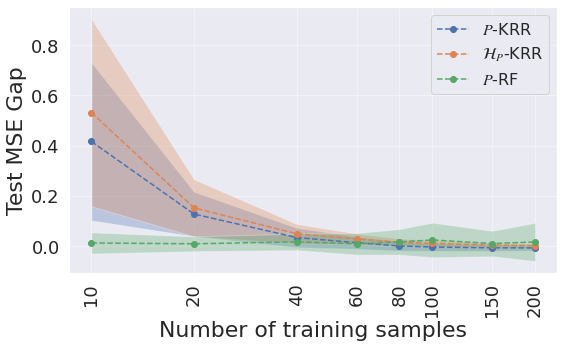

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

ntrain = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(ntrain, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(ntrain, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(ntrain, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(ntrain, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(ntrain, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(ntrain, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xscale('log')
ax.set_xticks(ntrain)
ax.set_xticklabels(ntrain, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel('Number of training samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

### semi_prop

In [57]:
dirpaths = glob('../experiments/data/outputs/semi_prop/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'semi_prop': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, semi_prop = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['semi_prop'].append(semi_prop)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df[r'Gap $P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-after']
krr_scores_df[r'Gap $\mathcal{H}_P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-before']
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('semi_prop').aggregate(['mean', 'std'])

rf_scores = {'RF-baseline': [], 'RF-after': [], 'semi_prop': [], 'seed': []}
with open('../experiments/data/outputs/semi_prop/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'semi_prop']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'semi_prop']
rf_scores_df[r'Gap $P$-RF'] = rf_scores_df['RF-baseline'] - rf_scores_df['RF-after']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('semi_prop').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)

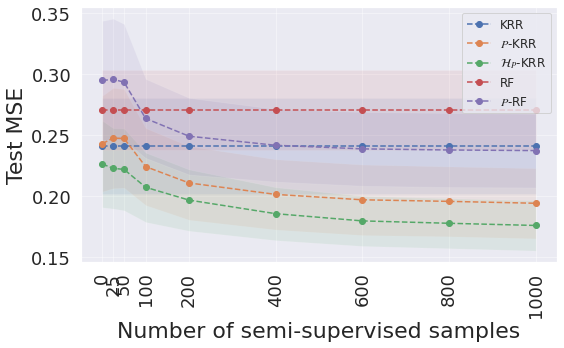

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

semi_prop = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(semi_prop, KRR_baseline_mean, ls='--', marker='o', label='KRR')
ax.fill_between(semi_prop, KRR_baseline_lb, KRR_baseline_ub, alpha=0.1)

ax.plot(semi_prop, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(semi_prop, KRR_after_lb, KRR_after_ub, alpha=0.1)

ax.plot(semi_prop, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(semi_prop, KRR_before_lb, KRR_before_ub, alpha=0.1)

ax.plot(semi_prop, RF_baseline_mean, ls='--', marker='o', label='RF')
ax.fill_between(semi_prop, RF_baseline_lb, RF_baseline_ub, alpha=0.1)

ax.plot(semi_prop, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(semi_prop, RF_after_lb, RF_after_ub, alpha=0.1)

# ax.set_xscale('log')
ax.set_xticks(semi_prop)
ax.set_xticklabels(semi_prop, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel('Number of semi-supervised samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

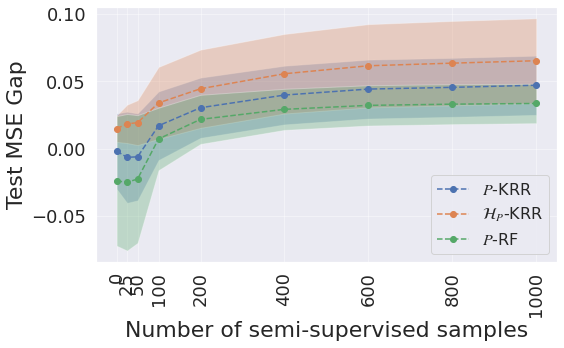

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

semi_prop = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(semi_prop, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(semi_prop, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(semi_prop, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(semi_prop, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(semi_prop, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(semi_prop, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xticks(semi_prop)
ax.set_xticklabels(semi_prop, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel('Number of semi-supervised samples', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

### Dim $X_2$

In [70]:
dirpaths = glob('../experiments/data/outputs/d_X2/mvn_experiment/seed_*')
krr_scores = {'KRR-baseline':[], 'KRR-after':[], 'KRR-before':[], 'd_X2': [], 'seed': []}
for dirpath in dirpaths:
    tokens = dirpath.split('/')[-1].split('_')
    seed, semi_prop = int(tokens[1]), float(tokens[-1])
    with open(os.path.join(dirpath, 'scores.metrics'), "r") as f:
        foo = yaml.safe_load(f)
        krr_scores['KRR-baseline'].append(foo['baseline'])
        krr_scores['KRR-after'].append(foo['after'])
        krr_scores['KRR-before'].append(foo['before'])
        krr_scores['d_X2'].append(semi_prop)
        krr_scores['seed'].append(seed)
krr_scores_df = pd.DataFrame(krr_scores)
krr_scores_df[r'Gap $P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-after']
krr_scores_df[r'Gap $\mathcal{H}_P$-KRR'] = krr_scores_df['KRR-baseline'] - krr_scores_df['KRR-before']
krr_scores_df = krr_scores_df.drop('seed', axis=1).groupby('d_X2').aggregate(['mean', 'std'])


rf_scores = {'RF-baseline': [], 'RF-after': [], 'd_X2': [], 'seed': []}
with open('../experiments/data/outputs/d_X2/mvn_experiment/RF/scores.metrics', "r") as f:
    foo = yaml.safe_load(f)
    rf_scores_df = pd.DataFrame(foo)
    rf_scores_df = rf_scores_df[['baseline', 'after', 'seed', 'd_X2']]
    rf_scores_df.columns = ['RF-baseline', 'RF-after', 'seed', 'd_X2']
rf_scores_df[r'Gap $P$-RF'] = rf_scores_df['RF-baseline'] - rf_scores_df['RF-after']
rf_scores_df = rf_scores_df.drop('seed', axis=1).groupby('d_X2').aggregate(['mean', 'std'])

scores_df = pd.concat([krr_scores_df, rf_scores_df], axis=1)

In [71]:
scores_df

KRR-baseline           KRR-after           KRR-before            \
             mean       std      mean       std       mean       std   
d_X2                                                                   
1.0      0.191549  0.026776  0.207265  0.037721   0.198444  0.038701   
2.0      0.193575  0.029743  0.191296  0.028103   0.180247  0.025526   
3.0      0.241261  0.039483  0.224268  0.031606   0.207332  0.028480   
4.0      0.229695  0.037340  0.206154  0.022474   0.183166  0.023852   
5.0      0.284556  0.048476  0.239674  0.035567   0.209970  0.032598   
6.0      0.386093  0.063757  0.301650  0.038783   0.270345  0.037664   
7.0      0.443357  0.072479  0.335834  0.043771   0.301717  0.046824   
8.0      0.547374  0.076639  0.413316  0.052123   0.372804  0.057920   

     Gap $P$-KRR           Gap $\mathcal{H}_P$-KRR           RF-baseline  \
            mean       std                    mean       std        mean   
d_X2                                                                       
1.0    -0.015716  0.029871               -0.006895  0.030493    0.288763   
2.0     0.002278  0.026829                0.013327  0.020648    0.269832   
3.0     0.016993  0.025452                0.033929  0.026721    0.270939   
4.0     0.023541  0.027712                0.046528  0.029341    0.253892   
5.0     0.044883  0.034521                0.074586  0.039407    0.245397   
6.0     0.084444  0.043289                0.115749  0.052815    0.262875   
7.0     0.107523  0.043613                0.141639  0.051516    0.241956   
8.0     0.134059  0.043037                0.174571  0.060378    0.249933   

                RF-after           Gap $P$-RF            
           std      mean       std       mean       std  
d_X2                                                     
1.0   0.031637  0.309035  0.043695  -0.020271  0.027100  
2.0   0.021934  0.256029  0.037429   0.013803  0.033614  
3.0   0.032754  0.263744  0.032434   0.007195  0.023189  
4.0   0.024723  0.223195  0.038935   0.030696  0.031717  
5.0   0.025558  0.225715  0.039504   0.019682  0.036822  
6.0   0.044781  0.254661  0.067987   0.008214  0.041358  
7.0   0.034956  0.242479  0.047680  -0.000523  0.031695  
8.0   0.044708  0.265921  0.061586  -0.015988  0.041569

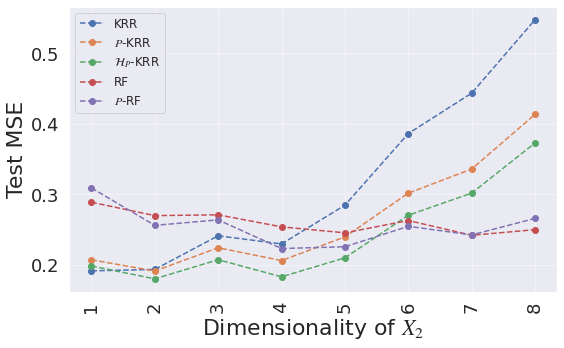

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 12
labelsize = 18

d_X2 = scores_df.index.values.astype(int)

KRR_baseline_mean = scores_df['KRR-baseline']['mean']
KRR_baseline_ub = KRR_baseline_mean + scores_df['KRR-baseline']['std']
KRR_baseline_lb = KRR_baseline_mean - scores_df['KRR-baseline']['std']

KRR_after_mean = scores_df['KRR-after']['mean']
KRR_after_ub = KRR_after_mean + scores_df['KRR-after']['std']
KRR_after_lb = KRR_after_mean - scores_df['KRR-after']['std']

KRR_before_mean = scores_df['KRR-before']['mean']
KRR_before_ub = KRR_before_mean + scores_df['KRR-before']['std']
KRR_before_lb = KRR_before_mean - scores_df['KRR-before']['std']

RF_baseline_mean = scores_df['RF-baseline']['mean']
RF_baseline_ub = RF_baseline_mean + scores_df['RF-baseline']['std']
RF_baseline_lb = RF_baseline_mean - scores_df['RF-baseline']['std']

RF_after_mean = scores_df['RF-after']['mean']
RF_after_ub = RF_after_mean + scores_df['RF-after']['std']
RF_after_lb = RF_after_mean - scores_df['RF-after']['std']


ax.plot(d_X2, KRR_baseline_mean, ls='--', marker='o', label='KRR')
# ax.fill_between(d_X2, KRR_baseline_lb, KRR_baseline_ub, alpha=0.3)

ax.plot(d_X2, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
# ax.fill_between(d_X2, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(d_X2, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
# ax.fill_between(d_X2, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(d_X2, RF_baseline_mean, ls='--', marker='o', label='RF')
# ax.fill_between(d_X2, RF_baseline_lb, RF_baseline_ub, alpha=0.3)

ax.plot(d_X2, RF_after_mean , ls='--', marker='o', label=r'$P$-RF')
# ax.fill_between(d_X2, RF_after_lb, RF_after_ub, alpha=0.3)

# ax.set_xscale('log')
ax.set_xticks(d_X2)
ax.set_xticklabels(d_X2, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE", fontsize=fontsize)
ax.set_xlabel(r'Dimensionality of $X_2$', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()

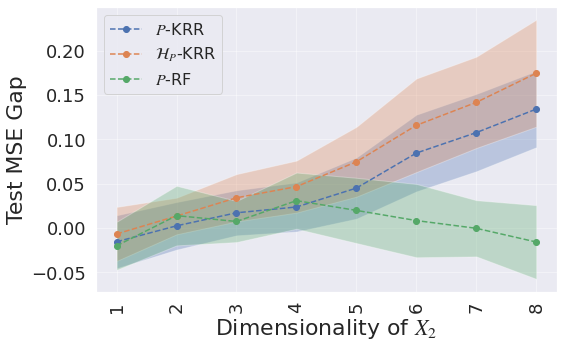

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fontsize = 22
legendsize = 16
labelsize = 18

d_X2 = scores_df.index.values.astype(int)

KRR_after_mean = scores_df['Gap $P$-KRR']['mean']
KRR_after_ub = KRR_after_mean + scores_df['Gap $P$-KRR']['std']
KRR_after_lb = KRR_after_mean - scores_df['Gap $P$-KRR']['std']

KRR_before_mean = scores_df['Gap $\mathcal{H}_P$-KRR']['mean']
KRR_before_ub = KRR_before_mean + scores_df['Gap $\mathcal{H}_P$-KRR']['std']
KRR_before_lb = KRR_before_mean - scores_df['Gap $\mathcal{H}_P$-KRR']['std']

RF_after_mean = scores_df['Gap $P$-RF']['mean']
RF_after_ub = RF_after_mean + scores_df['Gap $P$-RF']['std']
RF_after_lb = RF_after_mean - scores_df['Gap $P$-RF']['std']


ax.plot(d_X2, KRR_after_mean, ls='--', marker='o', label=r'$P$-KRR')
ax.fill_between(d_X2, KRR_after_lb, KRR_after_ub, alpha=0.3)

ax.plot(d_X2, KRR_before_mean, ls='--', marker='o', label=r'$\mathcal{H}_P$-KRR')
ax.fill_between(d_X2, KRR_before_lb, KRR_before_ub, alpha=0.3)

ax.plot(d_X2, RF_after_mean, ls='--', marker='o', label=r'$P$-RF')
ax.fill_between(d_X2, RF_after_lb, RF_after_ub, alpha=0.3)

ax.set_xticks(d_X2)
ax.set_xticklabels(d_X2, rotation=90)
ax.tick_params(labelsize=12)

ax.set_ylabel("Test MSE Gap", fontsize=fontsize)
ax.set_xlabel(r'Dimensionality of $X_2$', fontsize=fontsize)


ax.grid(alpha=0.4)
ax.tick_params(labelsize=labelsize)
plt.legend(fontsize=legendsize)
plt.tight_layout()
plt.show()